In [6]:
# Core
import os, json, subprocess, sys, time
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Project modules
from src.data.prepare_datasets import prepare_all
from src.data.load_text import load_ud_ewt, load_go_emotions
from src.traces.store import TraceStore

In [7]:
# Will create data/processed/{ud_ewt.parquet, go_emotions.parquet, ...}
paths = prepare_all("data/processed")
paths

[go_emotions] loading…
[go_emotions] processing split: train
[go_emotions] processing split: validation
[go_emotions] processing split: test
[go_emotions] wrote data/processed\go_emotions.parquet (54263 rows)


{'ud_ewt': 'data/processed\\ud_ewt.parquet',
 'go_emotions': 'data/processed\\go_emotions.parquet'}

In [25]:
ud_df = load_ud_ewt(token_level=False)
go_df, go_labels = load_go_emotions()

print("UD-EWT:", len(ud_df), "rows | splits:", ud_df["split"].value_counts().to_dict())
print("GoEmotions:", len(go_df), "rows | splits:", go_df["split"].value_counts().to_dict(), "| labels:", len(go_labels))
ud_df.sample(2)[["split","text"]]

UD-EWT: 16622 rows | splits: {'train': 12544, 'test': 2077, 'validation': 2001}
GoEmotions: 54263 rows | splits: {'train': 43410, 'test': 5427, 'validation': 5426} | labels: 28


,split,text
12548,validation,Bush also nominated A. Noel Anketell Kramer fo...
10116,train,You order at the counter and there is a space ...


In [9]:
go_df

,dataset,split,example_id,text,labels_idx,labels_names,labels_multihot
0,go_emotions,train,0ca6de2c8a0a3d11,My favourite food is anything I didn't have to...,[27],[neutral],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,go_emotions,train,b08327d7d205fb42,"Now if he does off himself, everyone will thin...",[27],[neutral],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,go_emotions,train,8aa4033120a87cd3,WHY THE FUCK IS BAYLESS ISOING,[2],[anger],"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,go_emotions,train,4112b99ecbf65e4f,To make her feel threatened,[14],[fear],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
4,go_emotions,train,ee45166f93e3a6d5,Dirty Southern Wankers,[3],[annoyance],"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...
54258,go_emotions,test,5a23a4f3126db178,Thanks. I was diagnosed with BP 1 after the ho...,[15],[gratitude],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
54259,go_emotions,test,f28f96558588e3d8,Well that makes sense.,[4],[approval],"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
54260,go_emotions,test,5562637ae0b0405c,Daddy issues [NAME],[27],[neutral],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
54261,go_emotions,test,a845e7fa53cf4922,So glad I discovered that subreddit a couple m...,[0],[admiration],"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [10]:
go_labels

['admiration',
 'amusement',
 'anger',
 'annoyance',
 'approval',
 'caring',
 'confusion',
 'curiosity',
 'desire',
 'disappointment',
 'disapproval',
 'disgust',
 'embarrassment',
 'excitement',
 'fear',
 'gratitude',
 'grief',
 'joy',
 'love',
 'nervousness',
 'optimism',
 'pride',
 'realization',
 'relief',
 'remorse',
 'sadness',
 'surprise',
 'neutral']

In [11]:
model = "roberta-base"
dataset = "ud_ewt"        # or "go_emotions"
split = "validation"
limit = 32
max_seq_len = 128

cmd = [
    sys.executable, "-m", "src.cli.extract_traces",
    "--model", model,
    "--dataset", dataset,
    "--split", split,
    "--limit", str(limit),
    "--max_seq_len", str(max_seq_len),
    "--capture", "attn", "qkv",
]
print("Running:", " ".join(cmd))
subprocess.run(cmd, check=True)

Running: c:\Users\mikol\venvs\Masters_env\Scripts\python.exe -m src.cli.extract_traces --model roberta-base --dataset ud_ewt --split validation --limit 32 --max_seq_len 128 --capture attn qkv


CompletedProcess(args=['c:\\Users\\mikol\\venvs\\Masters_env\\Scripts\\python.exe', '-m', 'src.cli.extract_traces', '--model', 'roberta-base', '--dataset', 'ud_ewt', '--split', 'validation', '--limit', '32', '--max_seq_len', '128', '--capture', 'attn', 'qkv'], returncode=0)

In [12]:
def latest_run_dir(root="traces", model=None, dataset=None, split=None):
    root = Path(root)
    if not root.exists(): 
        raise FileNotFoundError("No traces/ directory yet.")
    runs = sorted([p for p in root.iterdir() if p.is_dir()], key=os.path.getmtime)
    runs = runs[::-1]  # newest first
    for r in runs:
        # optional filters
        ok = True
        if model and model not in r.name: ok = False
        if dataset and dataset not in r.name: ok = False
        if split and f"_{split}_" not in r.name: ok = False
        if ok: 
            return str(r)
    return str(runs[0]) if runs else None

run_dir = latest_run_dir(model=model, dataset=dataset, split=split)
run_dir

'traces\\20251005-132439_roberta-base_ud_ewt_validation_n32'

In [13]:
run_dir = r"traces\\20250811-002634_roberta-base_ud_ewt_validation_n32"  
store = TraceStore(run_dir)

# length = number of non-pad tokens from attention_mask
store.tokens["len"] = store.tokens["attention_mask"].apply(lambda x: int(np.sum(x)))
store.tokens.sort_values("len", ascending=False).head(5)[["example_id","len","text"]].head(5)

,example_id,len,text
19,12809b2f1bb7a95e,64,It 's not quite as freewheeling an environment...
18,db2ff7a5d1dd37b8,46,"They work on Wall Street, after all, so when t..."
15,2381d9876142e5d6,41,It seems clear to me that the manhunt for high...
27,5ecd23336e2295b1,40,If the Israelis and the Palestinian leadership...
24,545227a583c988f2,40,The continued Israeli colonization of the occu...


In [14]:
store = TraceStore(run_dir)
print("meta:", json.dumps(store.meta, indent=2))
print("arrays:", store.arrays())
print("n,L,H,T,d_head:", store.n, store.L, store.H, store.T, store.d_head)

eid = store.tokens.iloc[0]["example_id"]
print("example_id:", eid)
print("text:", store.text(eid)[:180], "…")
enc = store.encodings(eid)
len(enc["input_ids"]), len(enc["attention_mask"]), len(enc["offset_mapping"]), len(enc["tokens"])

meta: {
  "run_id": "20250811-002634_roberta-base_ud_ewt_validation_n32",
  "model": "roberta-base",
  "dataset": "ud_ewt",
  "split": "validation",
  "n_examples": 32,
  "max_seq_len": 128,
  "num_layers": 12,
  "num_heads": 12,
  "head_dim": 64,
  "capture": [
    "attn",
    "qkv"
  ],
  "mlp_pool": null,
  "time": "2025-08-11 00:27:25"
}
arrays: {'enc_self_attn': (32, 12, 12, 128, 128), 'enc_self_q': (32, 12, 12, 128, 64), 'enc_self_k': (32, 12, 12, 128, 64), 'enc_self_v': (32, 12, 12, 128, 64)}
n,L,H,T,d_head: 32 12 12 128 64
example_id: 991d5555c8e55202
text: From the AP comes this story : …


(128, 128, 128, 128)

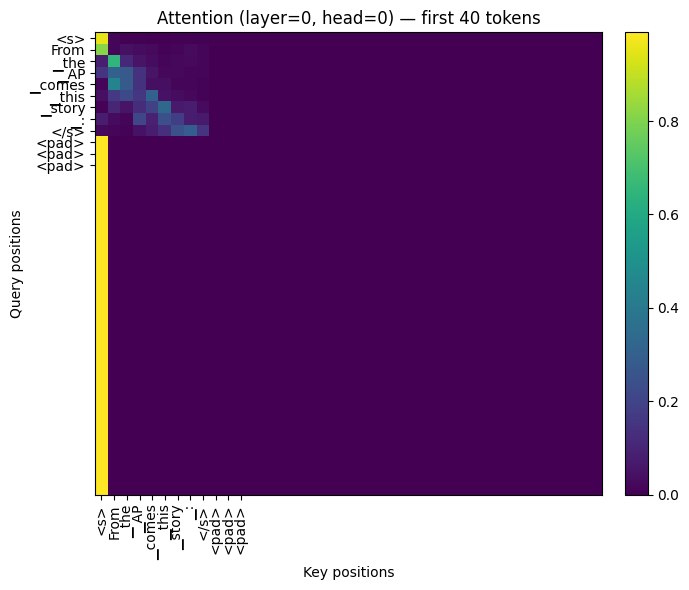

row sums (non-pad rows): 1.0 1.0 1.0


In [15]:
# Choose a head/layer & show a heatmap on the first N tokens
layer, head, N = 0, 0, 40

A = store.attn(eid, layer=layer, head=head)     # (T,T)
tok = enc["tokens"][:N]
mask = np.array(enc["attention_mask"][:N]).astype(bool)
M = A[:N,:N]

plt.figure(figsize=(7,6))
plt.imshow(M, aspect="auto")
plt.title(f"Attention (layer={layer}, head={head}) — first {N} tokens")
plt.xlabel("Key positions")
plt.ylabel("Query positions")
plt.colorbar(fraction=0.046, pad=0.04)
plt.xticks(range(min(N,12)), [t.replace("Ġ","▁") for t in tok[:12]], rotation=90)
plt.yticks(range(min(N,12)), [t.replace("Ġ","▁") for t in tok[:12]])
plt.tight_layout()
plt.show()

A = store.attn(eid, layer=layer, head=head)      # (T,T)
mask_full = np.array(enc["attention_mask"], dtype=bool)  # length T
row_sums = A[mask_full].sum(axis=-1)             # sums over all keys
print("row sums (non-pad rows):",
      float(row_sums.min()), float(row_sums.mean()), float(row_sums.max()))


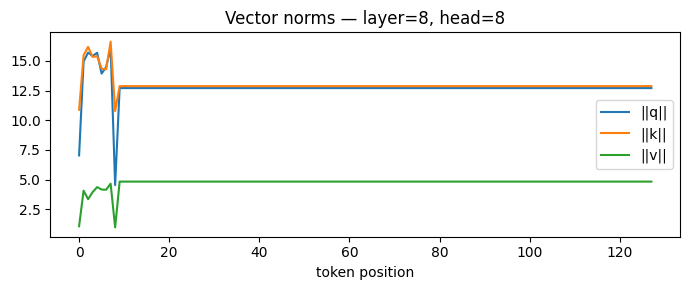

Means: inf inf 4.734
Stds : 1.064 0.6577 0.5034


C:\Users\mikol\AppData\Local\Temp\ipykernel_17716\1703133767.py:20: RuntimeWarning: overflow encountered in multiply
  print("Means:", round(q_norm.mean(),4), round(k_norm.mean(),4), round(v_norm.mean(),4))


In [ ]:
layer, head = 0, 0
Q = store.qkv(eid, "q", layer=layer, head=head)   # (T, d_head)
K = store.qkv(eid, "k", layer=layer, head=head)
V = store.qkv(eid, "v", layer=layer, head=head)

q_norm = np.linalg.norm(Q, axis=-1)
k_norm = np.linalg.norm(K, axis=-1)
v_norm = np.linalg.norm(V, axis=-1)

plt.figure(figsize=(7,3))
plt.plot(q_norm, label="||q||")
plt.plot(k_norm, label="||k||")
plt.plot(v_norm, label="||v||")
plt.title(f"Vector norms — layer={layer}, head={head}")
plt.xlabel("token position")
plt.legend()
plt.tight_layout()
plt.show()

print("Means:", round(q_norm.mean(),4), round(k_norm.mean(),4), round(v_norm.mean(),4))
print("Stds :", round(q_norm.std(),4),  round(k_norm.std(),4),  round(v_norm.std(),4))

In [23]:
text = store.text(eid)
pairs = list(zip(enc["tokens"][:20], enc["offset_mapping"][:20]))
for t,(s,e) in pairs:
    span = text[s:e] if (s or e) else ""
    print(f"{t:>12}  [{s:>3},{e:<3}]  '{span}'")

         <s>  [  0,0  ]  ''
        From  [  0,4  ]  'From'
        Ġthe  [  5,8  ]  'the'
         ĠAP  [  9,11 ]  'AP'
      Ġcomes  [ 12,17 ]  'comes'
       Ġthis  [ 18,22 ]  'this'
      Ġstory  [ 23,28 ]  'story'
          Ġ:  [ 29,30 ]  ':'
        </s>  [  0,0  ]  ''
       <pad>  [  0,0  ]  ''
       <pad>  [  0,0  ]  ''
       <pad>  [  0,0  ]  ''
       <pad>  [  0,0  ]  ''
       <pad>  [  0,0  ]  ''
       <pad>  [  0,0  ]  ''
       <pad>  [  0,0  ]  ''
       <pad>  [  0,0  ]  ''
       <pad>  [  0,0  ]  ''
       <pad>  [  0,0  ]  ''
       <pad>  [  0,0  ]  ''


[WindowsPath('results/figures/attn_l0_h0_first40.png'),
 WindowsPath('results/figures/qkv_norms_l0_h0.png')]

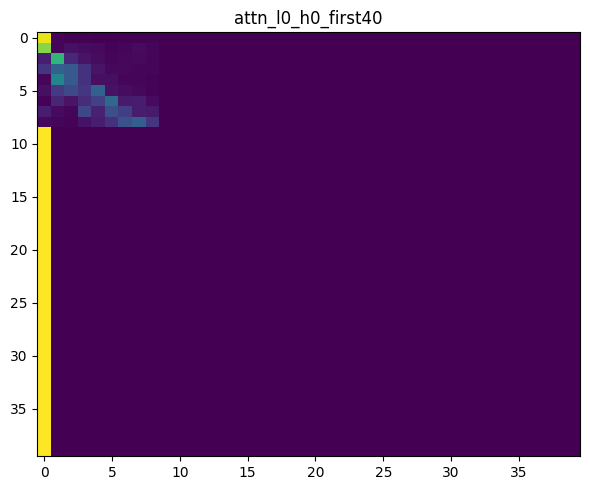

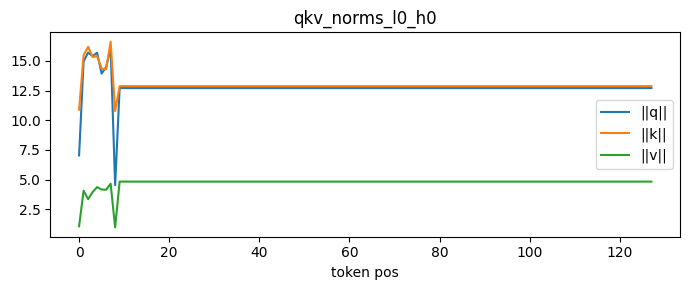

In [24]:
out = Path("results/figures"); out.mkdir(parents=True, exist_ok=True)

# Save last two figures again to disk (re-run small plots if needed)
plt.figure(figsize=(6,5))
plt.imshow(A[:40,:40], aspect="auto"); plt.title("attn_l0_h0_first40"); plt.tight_layout()
plt.savefig(out / "attn_l0_h0_first40.png", dpi=160)

plt.figure(figsize=(7,3))
plt.plot(q_norm, label="||q||"); plt.plot(k_norm, label="||k||"); plt.plot(v_norm, label="||v||")
plt.title("qkv_norms_l0_h0"); plt.xlabel("token pos"); plt.legend(); plt.tight_layout()
plt.savefig(out / "qkv_norms_l0_h0.png", dpi=160)

list(out.iterdir())